## "Temps de retour" calculation for piezometric level
Valentin Dall'Alba


### Description
This Jupyter notebook performs statistical analysis of piezometric water levels to calculate return periods. It includes:

- Processing of piezometric time series data
- Analysis of annual maxima and extreme events 
- Calculation of return periods using Gumbel distribution
- Generation of descriptive sheets with maps and plots
- Automated reporting of the most significant events
- Statistical visualization of water level distributions

The code uses data from multiple monitoring stations and generates comprehensive reports including geographical context and statistical analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from functions_piezo_return_analysis import *

### Import les données tests
Récupère les données de trois fichiers différents et les groupes dans une seule dataframe

In [2]:
# import les données de test
data_test = {}
path_data = 'data_test/'
name_to_load_test = ['test_bis']

for name in name_to_load_test:
    list_data = []

    for i in os.listdir(path_data) :
        if i.endswith('{}_HEAD_BSL.csv'.format(name)):
            list_data.append(pd.read_csv(path_data+i, skiprows=9, encoding='utf8', na_values=-9999))

    data_full  = pd.concat(list_data)
    data_full.rename(columns={data_full.columns[1]:'nvx_piezo'}, inplace=True)
    data_full['Date'] = pd.to_datetime(data_full['Date'], format='%d.%m.%Y')
    data_full.set_index('Date', inplace=True)
    data_full.dropna(how='any', inplace=True)
    data_test[name] = data_full
    print('-- Loaded data for piezo: ')
    print(name)

-- Loaded data for piezo: 
test_bis


In [3]:
data_test[name].head()

,nvx_piezo,ok
Date,,
1998-03-02,384.60,validée
1998-07-19,384.67,validée
1999-01-01,384.38,validée
1999-01-02,384.37,validée
1999-01-03,384.35,validée


### Test indépendemment les functions

Coefficients du polyfit : Pente = 33.684033791467, Ordonnée à l'origine = 57.410668645228796


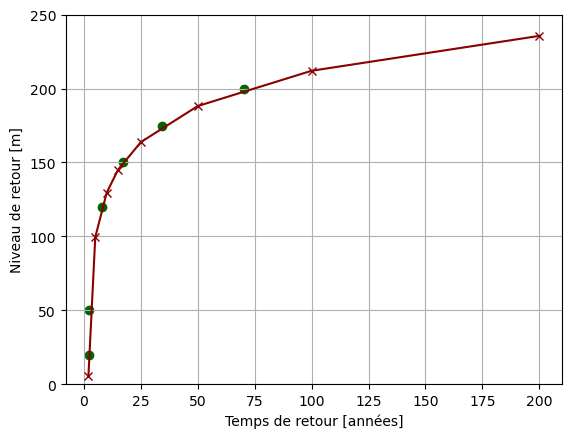

In [4]:
# Test des fonctions de ranking avec les données de test
extrem_event          = extract_annual_maxima(data_test['test_bis'])
donnees_triees, rangs = calculate_ranks(extrem_event)

# Test des fonctions de calcul avec les valeur de l'exemple de Romain excel "Montana P 20mm"
rangs          = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
donnees_triees = np.array([25, 26, 28, 28, 37, 37, 39, 40, 45, 45, 47, 48, 50, 50, 51, 51, 52, 59, 60, 61, 69, 69, 69, 71, 77, 79, 80, 82, 82, 86, 87, 90, 90, 101, 102, 112, 118, 123, 126, 149, 152, 166, 236])

T = np.array([2.01, 5, 10, 15, 25, 50, 100,200])
V = np.array([20,50,120,150,175,200])

prob_hazen_emp   = calculate_hazen_frequenc_empirique(rangs, len(donnees_triees))
u_gumbel_emp     = calculate_reduced_variable_empirique(prob_hazen_emp)
coefficients_emp = calculate_polyfit(u_gumbel_emp, donnees_triees, verbose=True) 

value_ = value_from_return_period(coefficients_emp[1], coefficients_emp[0], T)
temps_ = return_period_from_value(coefficients_emp[1], coefficients_emp[0], V)

#plotting pour verifier la cohérence des fonctions et des temps de retour et valeurs
plt.plot(T, value_, label="Données", color='darkred', marker='x')
plt.xlabel("Temps de retour [années]")
plt.ylabel("Niveau de retour [m]")
plt.scatter(temps_, V, color='darkgreen', marker='o')
plt.ylim(0, 250)
plt.grid();

### Effectue l'analyse des temps de retour sur les données complètes et plot les différents graphiques de l'analyse

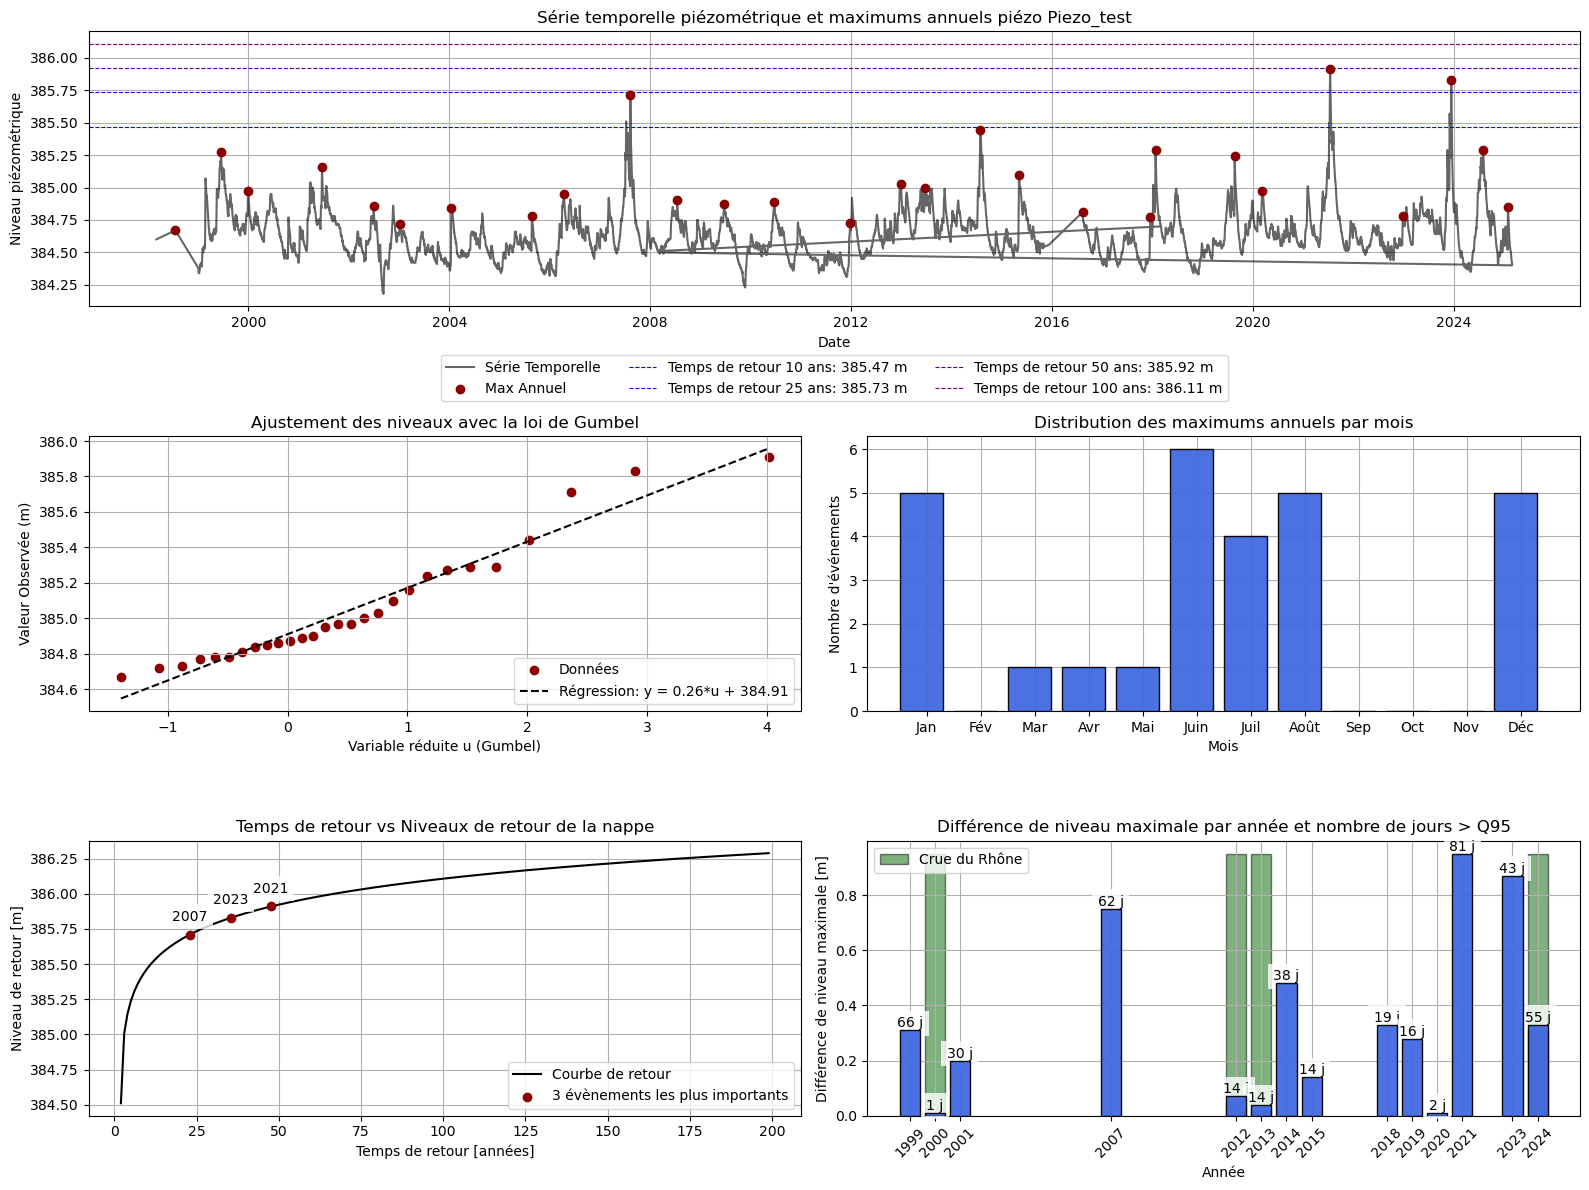

In [5]:
df, data_plot = max_serie_analysis(data_test['test_bis'])
plot_max_serie_analysis(data_plot, 'Piezo_test', 'results_test/test_data_treatment_return_time.png')

## Effectue l'analyse complète finale sur des données piézométriques et enregistre la fiche descriptive

In [11]:
#Load piezo information and get the altitude of the natural terrain
path_piezo_data = 'data_test'
info_piezo      = pd.read_csv(path_piezo_data+'/data_info_piezo_test.csv', encoding='latin', sep=';')

#Get the altitude of the TN automatically from the map geo admin service
info_piezo['TN']  = [get_high_res_swissalti3d_elevation(x, y) for x, y in zip(info_piezo['x'], info_piezo['y'])]

#load the different information for creating the sheets
data_load = info_piezo[info_piezo['load']=='Yes']
name_load = data_load['name'].values    
x_load    = data_load['x'].values
y_load    = data_load['y'].values
TN_load   = [float(f) for f in data_load['TN'].values]
id_load   = data_load['Id cantonal'].values
com_load  = data_load['Commune'].values

#load all the data from different file and get important information
data = {}
for name in name_load:
    list_data = []

    #get the piezometric data
    for i in os.listdir(path_piezo_data):
        if i.endswith('{}_HEAD_BSL.csv'.format(name)):
            list_data.append(pd.read_csv(path_piezo_data+'/'+i, skiprows=9, encoding='utf8', na_values=-9999))
    
    #retrieve some information
    data_full  = pd.concat(list_data)
    data_full.rename(columns={data_full.columns[1]:'nvx_piezo'}, inplace=True)
    data_full['Date'] = pd.to_datetime(data_full['Date'], format='%d.%m.%Y')
    data_full.set_index('Date', inplace=True)
    data_full.dropna(how='any', inplace=True)
    data_full = data_full[~data_full.index.duplicated(keep='first')]
    data_full.sort_index(inplace=True)
    data[name] = data_full
    print('-- Loaded data for piezo: ')
    print(name)

-- Loaded data for piezo: 
piezo_test


In [7]:
#create the map image to be add to the descriptive sheet of the piezometric data information
path_image = 'results_test/'

for x,y,name in zip(x_load, y_load, name_load):
    map_ = create_map(x, y)
    save_map_as_image(map_, path_image + 'map_{}.png'.format(name))
    print('-- Created map for piezo: ')
    print(name)

-- Created map for piezo: 
piezo_test


results_test/map_piezo_test.png


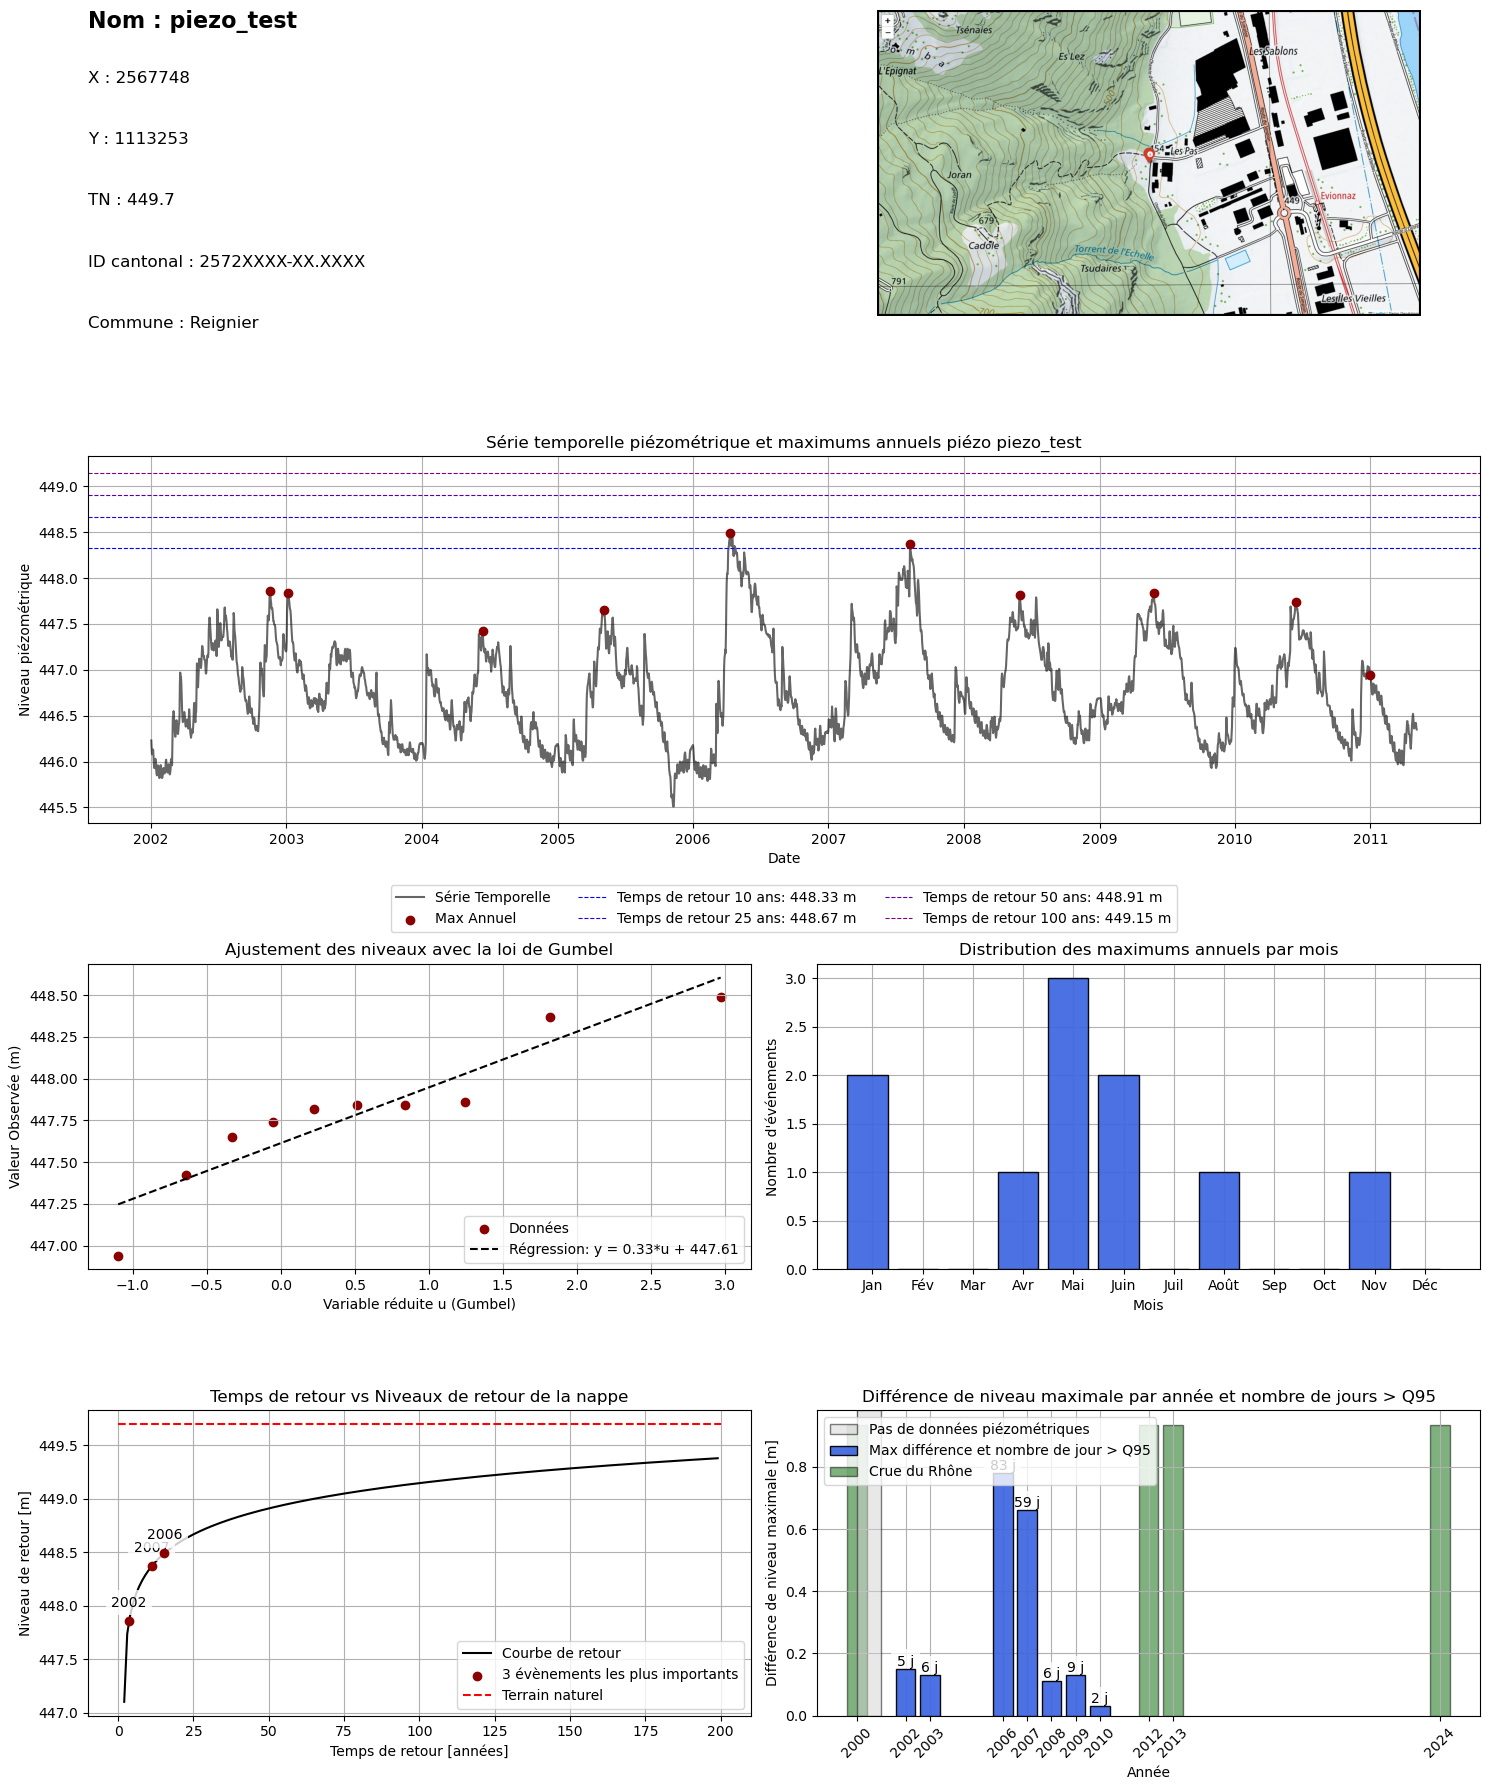

-- Created full analysis sheet for piezo: 
piezo_test


In [ ]:
#create the full sheet informative of the return distribution of yearly major event
df_all = {}

#print the map and save them
for name, x, y, TN, id, com in zip(name_load, x_load, y_load, TN_load, id_load, com_load):
    df, data_plot = max_serie_analysis(data[name])

    # Plotting
    extr         = plot_max_serie_analysis_full(data_plot, name, x, y, TN, id, com, path_image, path_to_save=path_image+'fiche_piezo_test.png', to_plot=True)
    df_all[name] = extr
    print('-- Created full analysis sheet for piezo: ')
    print(name)

In [9]:
# Create a dictionary to store the most important temps de retour for each piezo
store_data_path = 'data_test/'
most_important_temps_retour = {}

# Iterate through each piezo in df_all
for name, df in df_all.items():
    # Find the row with the maximum temps_retour
    most_important_row = df.loc[df['temps_retour'].idxmax()]
    
    # Get the corresponding year and month
    year = most_important_row.name.year
    month = most_important_row.name.month

    # Convert month number to month name in French
    month_name = pd.to_datetime(f'{year}-{month}-01').strftime('%B')

    # Store the result in the dictionary
    most_important_temps_retour[name] = {
        'nvx_piezo': most_important_row['nvx_piezo'],
        'temps_retour': most_important_row['temps_retour'],
        'year_month': f'{month_name} {year}'    }

# Convert the dictionary to a DataFrame for better visualization
most_important_temps_retour_df = pd.DataFrame(most_important_temps_retour).T
most_important_temps_retour_df.to_csv(store_data_path+'most_important_temps_retour_.csv', sep=';')
most_important_temps_retour_df.head()

,nvx_piezo,temps_retour,year_month
piezo_test,448.49,15.313176,April 2006
